In [874]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/hl2ss/viewer")
import cv2
import trimesh
import pyrender

%matplotlib inline

In [875]:
from mpl_toolkits import mplot3d
import json
import hl2ss
import hl2ss_3dcv
from PoseVisualizer import CameraPoseVisualizer

In [876]:
CALIB_PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/'
def get_all_calibration():
    calib_pv = hl2ss_3dcv._load_calibration_pv(CALIB_PATH+'calibrations/personal_video')
    calib_lt = hl2ss_3dcv._load_calibration_rm_depth_longthrow(CALIB_PATH+'calibrations/rm_depth_longthrow')
    calib_ahat = hl2ss_3dcv._load_calibration_rm_depth_ahat(CALIB_PATH+'calibrations/rm_depth_ahat')
    calib_rf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightfront')
    calib_lf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftfront')
    calib_rr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightright')
    calib_lr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftleft')
    
    uv2xy = hl2ss_3dcv.compute_uv2xy(calib_ahat.intrinsics, hl2ss.Parameters_RM_DEPTH_AHAT.WIDTH, hl2ss.Parameters_RM_DEPTH_AHAT.HEIGHT)
    xy1, scale = hl2ss_3dcv.rm_depth_compute_rays(uv2xy, calib_ahat.scale)
    
    #return all calibrations + xy1 + scale
    return calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr, xy1, scale

In [877]:
calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr, xy, scale = get_all_calibration()

### Reviewing PyRender Code

In [1174]:
MESH_PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/john_place/'

In [1175]:
#adding scene to interface with pyrender
fuze_trimesh = trimesh.load(MESH_PATH+'john_scene.obj')
mesh = pyrender.Mesh.from_trimesh(fuze_trimesh)
scene = pyrender.Scene()
scene.add(mesh,name='scene')

In [1176]:
#adding camera to the scene
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
s = np.sqrt(2)/2

#camera pose should be a 4x4
# [R|t]
# [0|1]
# camera_pose = np.eye(4)

s = np.sqrt(2)/2
camera_pose = np.array([
    [0.0, -s,   s,   0.3],
    [1.0,  0.0, 0.0, 0.0],
    [0.0,  s,   s,   0.35],
    [0.0,  0.0, 0.0, 1.0],
])

scene.add(camera, name='camera',pose=camera_pose) #adding camera at the pose

#adding light (for rgb rendering)
light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,
                           innerConeAngle=np.pi/16.0,
                           outerConeAngle=np.pi/6.0)

scene.add(light, name='light',pose=camera_pose)

In [1177]:
r = pyrender.OffscreenRenderer(400, 400) #specifies heightxwidth of image
color, depth = r.render(scene) #create the images

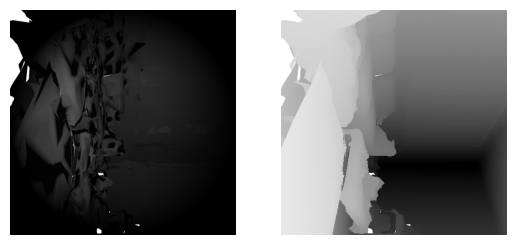

In [1178]:
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

In [1179]:
for node in scene.get_nodes():
    print(node.name)
    print(scene.get_pose(node))

scene
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
camera
[[ 0.         -0.70710678  0.70710678  0.3       ]
 [ 1.          0.          0.          0.        ]
 [ 0.          0.70710678  0.70710678  0.35      ]
 [ 0.          0.          0.          1.        ]]
light
[[ 0.         -0.70710678  0.70710678  0.3       ]
 [ 1.          0.          0.          0.        ]
 [ 0.          0.70710678  0.70710678  0.35      ]
 [ 0.          0.          0.          1.        ]]


In [1180]:
for node in scene.get_nodes():
    if node.name == 'camera':
        s_pose = np.eye(4)
        # s_pose[:,3] = np.array([-0.3,0.02,-0.03,1])
        # s_pose[:,3] = np.array([0,0,1,1])
        scene.set_pose(node,s_pose)
        
        # +x goes right of couch
        # +y goes up
        # +z goes into wall
    elif node.name == 'light':
        scene.set_pose(node,np.eye(4))

In [1181]:
r = pyrender.OffscreenRenderer(400, 400) #specifies heightxwidth of image
color, depth = r.render(scene) #create the images

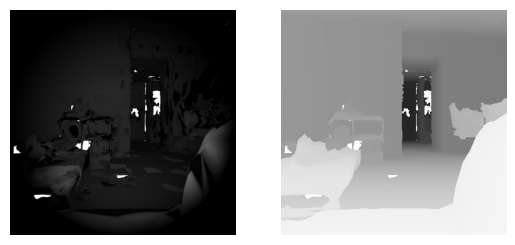

In [1182]:
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

### NOTE

the above shows how you can set the pose and use the offscreen render to get the pose each time

## Interfacing with Scene

In [1186]:
 #code to load up poses
PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/john_place/vid1/'

with open(PATH+'vlc1_pose.json') as f: # vlc LF
    j_vlc_lf = json.load(f)
with open(PATH+'vlc3_pose.json') as f:
    j_vlc_rf = json.load(f)
with open(PATH+'depth_ahat_pose.json') as f: # long throw
    j_ahat = json.load(f)
with open(PATH+'pv_pose.json') as f: # long throw
    j_pv = json.load(f)
with open(PATH+'vlc2_pose.json') as f: # long throw
    j_vlc_ll = json.load(f)
with open(PATH+'vlc4_pose.json') as f: # long throw
    j_vlc_rr = json.load(f)
    
tstamps = sorted(j_ahat.keys())

def get_im(tstamp, root_path):
    return cv2.imread(root_path+tstamp+'.png')

def get_posed_data(idx, sensor_name, pose_name):
    tstamp_name = tstamps[idx]
    im = cv2.imread(PATH+sensor_name+'/'+tstamp_name+'.png')
    pose = pose_name[tstamp_name]
    return im, np.array(pose)

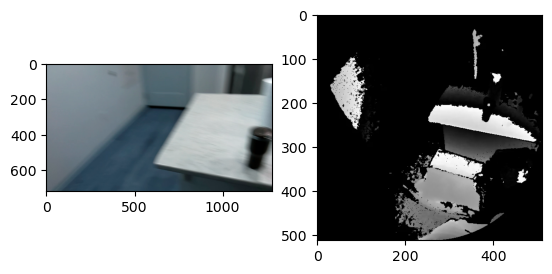

In [1281]:
#display code to see what we see throughout time
time = 1000

im_pv, pose_pv = get_posed_data(time,'pv',j_pv)
im_ahat, pose_ahat = get_posed_data(time,'depth_ahat',j_ahat)

im_lf, pose_lf = get_posed_data(time,'vlc_lf',j_vlc_lf)
im_ll, pose_ll = get_posed_data(time,'vlc_ll',j_ahat)
im_rf, pose_rf = get_posed_data(time,'vlc_rf',j_ahat)
im_rr, pose_rr = get_posed_data(time,'vlc_rr',j_ahat)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_pv)
axs[1].imshow(im_ahat)

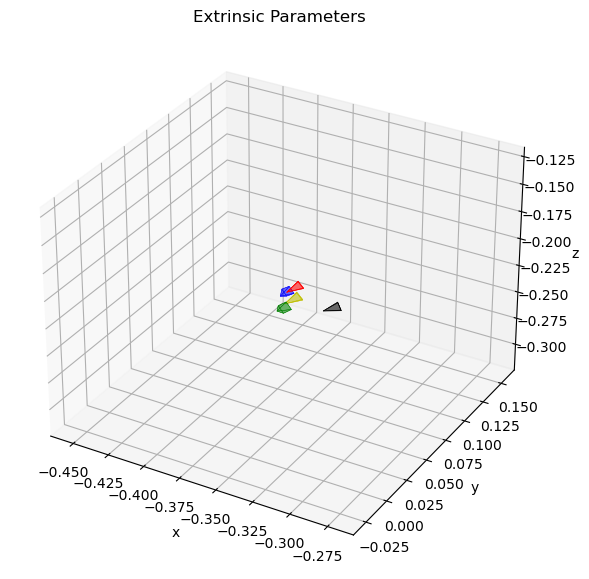

In [1189]:
scale = 0.1
focal_scale = 0.01
x,y,z = pose_pv.T[:3,3]
visualizer = CameraPoseVisualizer([x-scale, x+scale], [y-scale,y+scale], [z-scale, z+scale])

#extrinsic is 4x4
visualizer.extrinsic2pyramid(pose_pv.T @ np.linalg.inv(calib_lf.extrinsics.T), 'r', focal_len_scaled=focal_scale)
visualizer.extrinsic2pyramid(pose_pv.T @ np.linalg.inv(calib_rf.extrinsics.T), 'y', focal_len_scaled=focal_scale)
visualizer.extrinsic2pyramid(pose_pv.T @ np.linalg.inv(calib_ahat.extrinsics.T), 'k', focal_len_scaled=focal_scale)
visualizer.extrinsic2pyramid(pose_pv.T @ np.linalg.inv(calib_lr.extrinsics.T), 'b', focal_len_scaled=focal_scale)
visualizer.extrinsic2pyramid(pose_pv.T @ np.linalg.inv(calib_rr.extrinsics.T), 'g', focal_len_scaled=focal_scale)
visualizer.show()

In [1259]:
#adding scene to interface with pyrender
MESH_PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/john_place/'
intrinsics = calib_ahat.intrinsics.T[:3,:3]

flipper = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
# poser = pose_pv.T @ np.linalg.inv(calib_lf.extrinsics.T)
poser = pose_ahat.T


fuze_trimesh = trimesh.load(MESH_PATH+'john_scene.obj')
print(fuze_trimesh)
mesh = pyrender.Mesh.from_trimesh(fuze_trimesh)
scene = pyrender.Scene()
scene.add(mesh,name='scene')


camera = pyrender.IntrinsicsCamera(fx=intrinsics[0,0],fy=intrinsics[1,1],cx=intrinsics[0,2],cy=intrinsics[1,2])
scene.add(camera, name='camera',pose=poser)

light = pyrender.SpotLight(color=np.ones(3), intensity=4.0,
                           innerConeAngle=np.pi/2.0,
                           outerConeAngle=np.pi/2.0)

scene.add(light, name='light',pose=poser)

<trimesh.Trimesh(vertices.shape=(35743, 3), faces.shape=(64231, 3))>


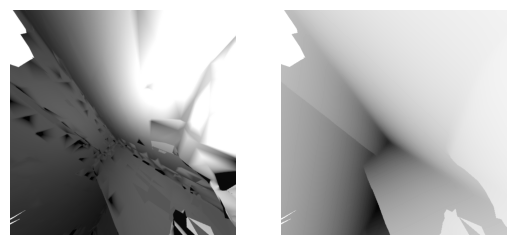

In [1248]:
r = pyrender.OffscreenRenderer(512, 512) #specifies heightxwidth of image
color, depth = r.render(scene) #create the images

# color = color.transpose(1,0,2)[:,::-1]
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

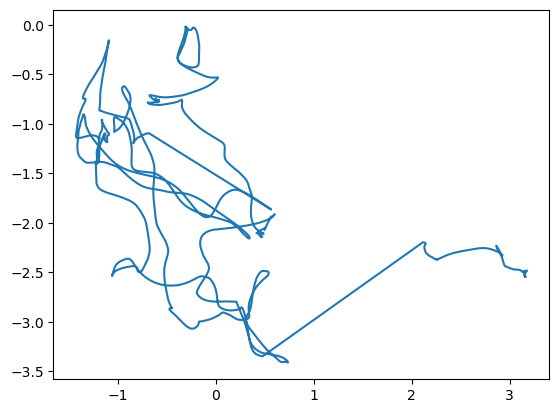

In [1318]:
tstep = 3000
xs = np.zeros(tstep)
ys = np.zeros(tstep)
zs = np.zeros(tstep)
for i in range(tstep):
    x,y,z = np.array(j_pv[tstamps[i]]).T[:3,3]
    
    xs[i] = x
    ys[i] = y
    zs[i] = z
    
plt.plot(xs,zs)
plt.show()